In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Helpers 
from src.dataset_functions import *
from src.fair_classifier_functions import *


In [73]:
salary_list = [100000, 125000, 150000, 175000, 200000, 225000, 250000]
datasets = create_multiple_datasets(create_binary_dataset_salary, salary_list)

In [74]:
privileged_groups= [{'sex':1}]
unprivileged_groups= [{'sex': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
               privileged_groups=privileged_groups)



In [75]:
rw_datasets = []
for dataset in datasets: 
    rw = RW.fit_transform(dataset)
    rw_datasets.append(rw)

In [76]:
means, impact = get_dataset_metrics_list(rw_datasets)

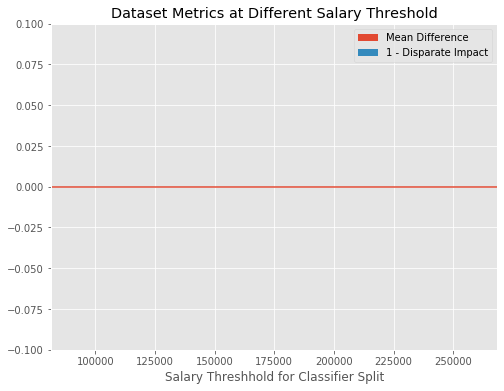

In [77]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(salary_list))

ax.bar(x_axis, means, label='Mean Difference' )
ax.bar(x_axis, impact, label='1 - Disparate Impact')
ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
ax.set_title('Dataset Metrics at Different Salary Threshold')
ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.set_ylim(-.1, .1)
ax.legend()
plt.savefig('images/model_rw_metrics')

In [78]:
train, val, test = create_split_lists(rw_datasets)

In [79]:
pred_list = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), train, val)

In [80]:
classifier_stats = get_classifier_metrics(val, pred_list)

In [81]:
classifier_stats

([0.892, 0.843, 0.776, 0.675, 0.631, 0.717, 0.725],
 [0.762, 0.746, 0.706, 0.662, 0.612, 0.653, 0.51],
 [-0.183, -0.16, -0.17, -0.164, -0.07, -0.076, 0.055],
 [-0.056, -0.023, -0.004, 0.0, -0.021, -0.038, 0.089],
 [0.059, 0.081, 0.132, 0.134, 0.148, 0.178, 0.332])

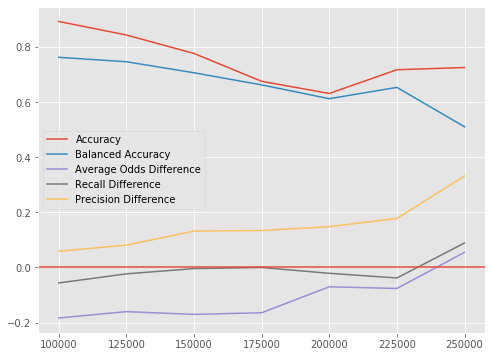

In [82]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(classifier_stats[0]))

ax.plot(x_axis, classifier_stats[0], label='Accuracy' )
ax.plot(x_axis, classifier_stats[1], label='Balanced Accuracy' )
ax.plot(x_axis, classifier_stats[2], label='Average Odds Difference' )
ax.plot(x_axis, classifier_stats[3], label='Recall Difference' )
ax.plot(x_axis, classifier_stats[4], label='Precision Difference' )

ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.legend()
plt.savefig('images/rw_classifier_metrics')

In [83]:
pred_mean, pred_di = get_dataset_metrics_list(pred_list)

In [84]:
train_mean, train_di = get_dataset_metrics_list(train)

In [85]:
val_mean, val_di = get_dataset_metrics_list(val)

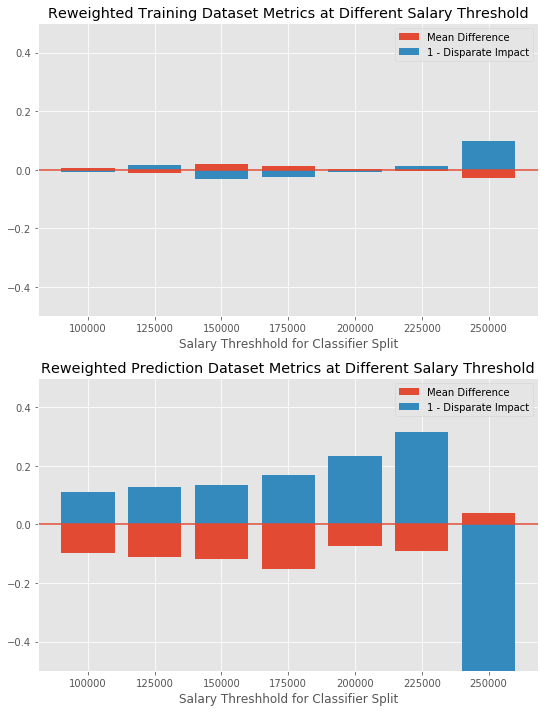

In [86]:
fig, axes = plt.subplots(2,1, figsize = (8,10))
x_axis = range(len(salary_list))

axes[0].bar(x_axis, val_mean, label='Mean Difference' )
axes[0].bar(x_axis, val_di, label='1 - Disparate Impact')
axes[0].axhline(0)
axes[0].set_xticks(x_axis)
axes[0].set_xticklabels(salary_list)
axes[0].set_title('Reweighted Testing Dataset Metrics at Different Salary Threshold')
axes[0].set_xlabel('Salary Threshhold for Classifier Split')
axes[0].set_ylim(-.5, .5)

axes[1].bar(x_axis, pred_mean, label='Mean Difference' )
axes[1].bar(x_axis, pred_di, label='1 - Disparate Impact')
axes[1].axhline(0)
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(salary_list)
axes[1].set_title('Reweighted Prediction Dataset Metrics at Different Salary Threshold')
axes[1].set_xlabel('Salary Threshhold for Classifier Split')
axes[1].set_ylim(-.5, .5)

plt.tight_layout()
axes[0].legend()
axes[1].legend()
plt.savefig('images/rw_side_by_side_metrics')